# Introduction

The purpose of this notebook is to download new data from the german weather service (DWD). We use their ground observation network that includes a bit more than 1000 rainfall gauges. This script downloads all the metadata and then requests the actual data for a variable (precipitation_height), a temporal resolution, which will be monthly here and a temporal extract.
^
If you are on colab, you can mount your google drive to write the results directly there:

```python
from google.colab import drive
drive.mount('/gdrive')^
```

If you run local, you need to adjust the paths accordingly

In [ ]:
!pip install "wetterdienst>0.81"

In [1]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
request = DwdObservationRequest(
    parameter="precipitation_height",
    #parameter=[("precipitation_height", "more_precip"), ("temperature_air_mean_200", "kl")],
    resolution="monthly",
    #resolution="daily",
    start_date=datetime(2022, 1, 1),
    end_date=datetime(2024, 3, 1)
)

stations = request.all()
stations_df = stations.df.to_pandas()

<Axes: >

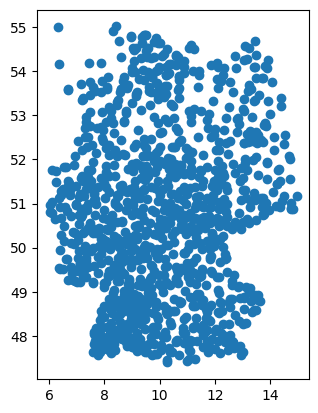

In [5]:
gdf = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude, crs=4326))
gdf.plot()

In [6]:
data = stations.values.all().df.drop_nulls()

/usr/local/lib/python3.10/dist-packages/wetterdienst/core/timeseries/values.py:193: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  date_range = date_range.map_elements(lambda date: date.replace(day=1).isoformat())


<Axes: >

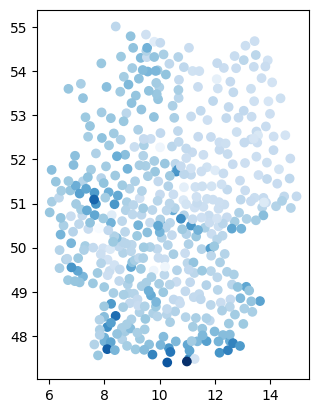

In [7]:
# join the yearly sum to the GeoDataFrame and use the value to color the map from above
sums_2023 = gdf.join(data.to_pandas().groupby('station_id').sum(numeric_only=True), on="station_id").dropna()
sums_2023.plot(column='value', cmap='Blues')

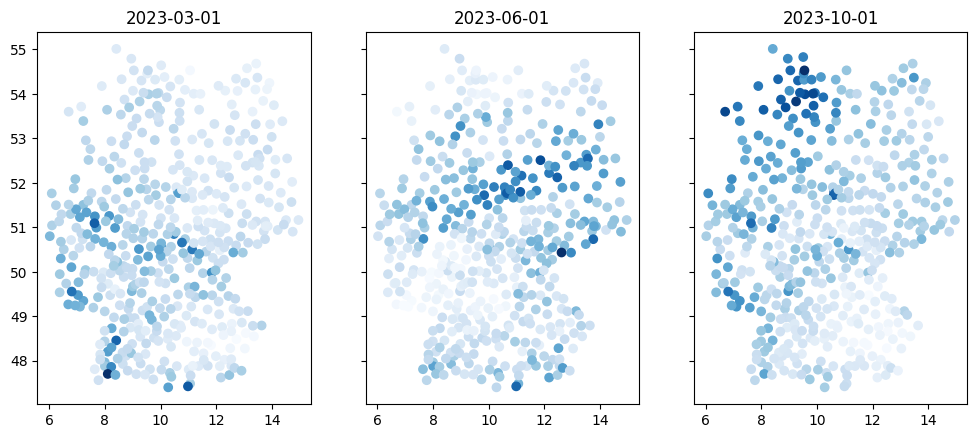

In [8]:
# use the filter function of pandas to select a month and plot
months = ['2023-03-01', '2023-06-01', '2023-10-01']
month_sums = []
fig, axes = plt.subplots(1, len(months), figsize=(12, len(months) * 10), sharey=True)

for i, month in enumerate(months):
  monthly = data.to_pandas().where(data.to_pandas().date == month).dropna(how='all')
  sums = gdf.join(monthly.groupby('station_id').sum(numeric_only=True), on="station_id").dropna()
  month_sums.append(sums)
  sums.plot(ax=axes.flatten()[i], column='value', cmap='Blues')
  axes.flatten()[i].set_title(month)

**If you are on colab, you need to connect you gdrive first, if you are locally, you need to adjust the path**.

In [13]:
# gdrive path
p = '/content/drive/MyDrive/Geostatistics/content/data/'
# save the sums and the extracts
sums_2023.to_csv(p + 'precipitation_sums_2022-2023.csv', index=False)

for sums, month in zip(month_sums, months):
  sums.to_csv(p + f'precipitation_sums_{month}.csv', index=False)

In [10]:
gdf

,station_id,start_date,end_date,latitude,longitude,height,name,state,geometry
0,00001,1931-01-01 00:00:00+00:00,1986-06-30 00:00:00+00:00,47.8413,8.8493,478.0,Aach,Baden-Württemberg,POINT (8.84930 47.84130)
1,00003,1851-01-01 00:00:00+00:00,2011-03-31 00:00:00+00:00,50.7827,6.0941,202.0,Aachen,Nordrhein-Westfalen,POINT (6.09410 50.78270)
2,00044,1971-03-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,52.9336,8.2370,44.0,Großenkneten,Niedersachsen,POINT (8.23700 52.93360)
3,00052,1973-01-01 00:00:00+00:00,2001-12-31 00:00:00+00:00,53.6623,10.1990,46.0,Ahrensburg-Wulfsdorf,Schleswig-Holstein,POINT (10.19900 53.66230)
4,00061,1975-07-01 00:00:00+00:00,1978-08-31 00:00:00+00:00,48.8443,12.6171,339.0,Aiterhofen,Bayern,POINT (12.61710 48.84430)
...,...,...,...,...,...,...,...,...,...
1144,19510,1950-01-01 00:00:00+00:00,1970-12-31 00:00:00+00:00,51.1000,12.3300,159.0,Lucka,Thüringen,POINT (12.33000 51.10000)
1145,19579,1971-01-01 00:00:00+00:00,2005-10-31 00:00:00+00:00,47.8194,8.3348,875.0,Bonndorf,Baden-Württemberg,POINT (8.33480 47.81940)
1146,19580,1975-01-01 00:00:00+00:00,2005-12-31 00:00:00+00:00,48.4951,9.4003,471.0,"Urach, Bad/Erms",Baden-Württemberg,POINT (9.40030 48.49510)
1147,19581,1974-06-01 00:00:00+00:00,2005-03-31 00:00:00+00:00,48.6671,8.4700,600.0,Enzklösterle/Schwarzwald,Baden-Württemberg,POINT (8.47000 48.66710)


In [11]:
data.to_pandas().where(data.to_pandas().station_id == "00044").dropna(how="all")

,station_id,dataset,parameter,date,value,quality
0,00044,climate_summary,precipitation_height,2022-01-01 00:00:00+00:00,47.4,3.0
1,00044,climate_summary,precipitation_height,2022-02-01 00:00:00+00:00,132.4,3.0
2,00044,climate_summary,precipitation_height,2022-03-01 00:00:00+00:00,21.2,3.0
3,00044,climate_summary,precipitation_height,2022-04-01 00:00:00+00:00,40.2,3.0
4,00044,climate_summary,precipitation_height,2022-05-01 00:00:00+00:00,49.0,3.0
5,00044,climate_summary,precipitation_height,2022-06-01 00:00:00+00:00,41.2,3.0
6,00044,climate_summary,precipitation_height,2022-07-01 00:00:00+00:00,67.8,3.0
7,00044,climate_summary,precipitation_height,2022-08-01 00:00:00+00:00,26.2,3.0
8,00044,climate_summary,precipitation_height,2022-09-01 00:00:00+00:00,92.7,3.0
9,00044,climate_summary,precipitation_height,2022-10-01 00:00:00+00:00,20.7,3.0
